In [1]:
!pip install transformers datasets evaluate scikit-learn torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [39]:
# Load the dataset
file_path = "/content/eng.csv"  # Adjust if your file is elsewhere in Colab
df = pd.read_csv(file_path)


In [40]:
# Check the dataset structure
print("Dataset Overview:")
print(df.head())

Dataset Overview:
                        id                                               text  \
0  eng_train_track_a_00001                                But not very happy.   
1  eng_train_track_a_00002  Well she's not gon na last the whole song like...   
2  eng_train_track_a_00003  She sat at her Papa's recliner sofa only to mo...   
3  eng_train_track_a_00004                    Yes, the Oklahoma city bombing.   
4  eng_train_track_a_00005                       They were dancing to Bolero.   

   Anger  Fear  Joy  Sadness  Surprise  
0      0     0    1        1         0  
1      0     0    1        0         0  
2      0     0    0        0         0  
3      1     1    0        1         1  
4      0     0    1        0         0  


In [41]:
# Preprocessing function for text and labels
def preprocess_data(df):
    # Remove rows with missing values
    df = df.dropna()

    # Clean text
    def clean_text(text):
        text = re.sub(r"http\S+", "", text)  # Remove URLs
        text = re.sub(r"[^A-Za-z0-9\s]", "", text)  # Remove special characters
        text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
        return text

    df['text'] = df['text'].apply(clean_text)

    # Normalize labels (ensure binary format)
    label_columns = ['Joy', 'Sadness', 'Fear', 'Anger', 'Surprise']
    for col in label_columns:
        df[col] = df[col].apply(lambda x: 1 if x > 0 else 0)  # Convert any positive value to 1

    # Combine labels into a single string for T5 fine-tuning
    df['labels'] = df[label_columns].apply(
        lambda row: ' '.join([f"{col}:{row[col]}" for col in label_columns]),
        axis=1
    )

    return df


In [42]:
# Preprocess the data
df = preprocess_data(df)

In [43]:
from sklearn.utils import resample

def balance_dataset(df):
    label_columns = ['Joy', 'Sadness', 'Fear', 'Anger', 'Surprise']

    # Identify the label with the most instances
    majority_class_size = max(df[label_columns].sum())

    # Oversample each label class
    balanced_dfs = []
    for col in label_columns:
        class_df = df[df[col] == 1]
        balanced_class_df = resample(
            class_df,
            replace=True,  # Oversample
            n_samples=majority_class_size,
            random_state=42
        )
        balanced_dfs.append(balanced_class_df)

    # Combine balanced classes
    balanced_df = pd.concat(balanced_dfs)
    return balanced_df

# Apply balancing if needed
df_balanced = balance_dataset(df)


In [44]:
# Split the dataset
train, temp = train_test_split(df, test_size=0.2, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

In [45]:
# Convert to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)

In [ ]:
dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

# Tokenize the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [47]:
# Tokenizer and Model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

In [48]:
# Tokenize the dataset
def tokenize_function(examples):
    inputs = ["predict emotions: " + snippet for snippet in examples["text"]]
    labels = examples["labels"]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(labels, max_length=32, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/2214 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Map:   0%|          | 0/277 [00:00<?, ? examples/s]

In [49]:
# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    logging_dir='./logs',
    logging_steps=100,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [50]:
# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
)

<ipython-input-50-a8098e9ca6ca>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [53]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.048500,0.055690
2,0.039800,0.062418
3,0.035500,0.070826
4,0.034000,0.068624
5,0.027600,0.073286


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=1385, training_loss=0.03662537788225856, metrics={'train_runtime': 731.5969, 'train_samples_per_second': 15.131, 'train_steps_per_second': 1.893, 'total_flos': 1963541708144640.0, 'train_loss': 0.03662537788225856, 'epoch': 5.0})

In [72]:
# Define the directory to save the model
output_dir = "./fine_tuned_t5"

# Save the model
trainer.save_model(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")


Model and tokenizer saved to ./fine_tuned_t5


In [74]:
from google.colab import drive
drive.mount('/content/drive')

# Save the model to a Google Drive folder
output_dir = "/content/drive/MyDrive/fine_tuned_t5"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model and tokenizer saved to /content/drive/MyDrive/fine_tuned_t5


In [75]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Define the directory where the model is saved
output_dir = "./fine_tuned_t5"

# Load the model
model = T5ForConditionalGeneration.from_pretrained(output_dir)

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained(output_dir)

print("Model and tokenizer loaded successfully!")


Model and tokenizer loaded successfully!


In [76]:
# Define a function to generate predictions
def generate_predictions(dataset):
    predictions = []
    ground_truths = []

    for example in dataset:
        input_text = "predict emotions: " + example["text"]
        input_ids = tokenizer(input_text, return_tensors="pt", max_length=128, truncation=True, padding="max_length").input_ids
        input_ids = input_ids.to(model.device)

        outputs = model.generate(input_ids, max_length=32)
        decoded_preds = tokenizer.decode(outputs[0], skip_special_tokens=True)

        predictions.append(decoded_preds)
        ground_truths.append(example["labels"])

    return predictions, ground_truths



In [77]:
# Generate predictions on the test dataset
test_dataset = dataset["test"]
predictions, ground_truths = generate_predictions(test_dataset)

In [83]:
# Preprocess predictions and ground truth for F1 calculation
# Convert the multi-label strings back to binary arrays for F1 computation
def process_labels(labels):
    emotions = ['Joy', 'Sadness', 'Fear', 'Anger', 'Surprise']
    label_arrays = []
    for label in labels:
        label_dict = {k: int(v) for k, v in (pair.split(":") for pair in label.split())}
        label_array = [label_dict[emotion] for emotion in emotions]
        label_arrays.append(label_array)
    return label_arrays

In [84]:
# Process predictions and ground truths
pred_arrays = process_labels(predictions)
true_arrays = process_labels(ground_truths)

In [85]:
# Compute F1 score
from sklearn.metrics import f1_score
f1 = f1_score(true_arrays, pred_arrays, average="weighted")
print("Weighted F1 Score on Test Dataset:", f1)

Weighted F1 Score on Test Dataset: 0.7481661533650893


In [86]:
f1_micro = f1_score(true_arrays, pred_arrays, average="micro")
print("Micro Average F1 Score:", f1_micro)


Micro Average F1 Score: 0.7554479418886199


<ipython-input-87-08823e7342d6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['F1 Score'], y=[f1], palette='viridis')


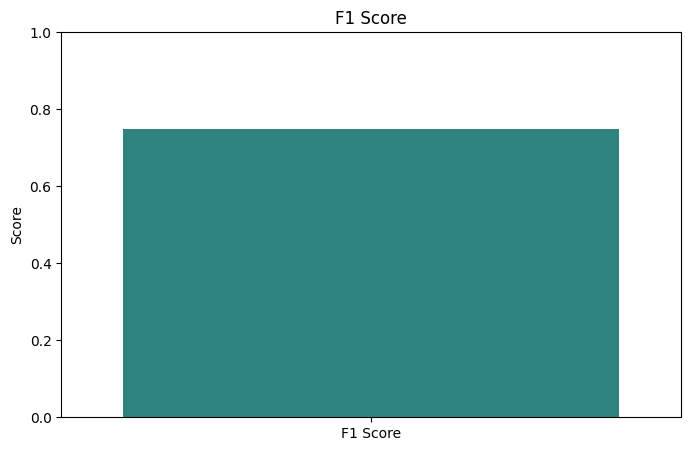

In [87]:
# Step 3: Visualize F1 Score
import matplotlib.pyplot as plt  # Import matplotlib
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.barplot(x=['F1 Score'], y=[f1], palette='viridis')
plt.title('F1 Score')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set limit from 0 to 1
plt.show()


In [63]:
# Define a function to predict emotions for a single input sentence
def predict_emotions(sentence):
    input_text = "predict emotions: " + sentence
    input_ids = tokenizer(input_text, return_tensors="pt", max_length=128, truncation=True, padding="max_length").input_ids
    input_ids = input_ids.to(model.device)

    # Generate predictions
    outputs = model.generate(input_ids, max_length=32)
    decoded_preds = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return decoded_preds



In [71]:
# Example sentence
new_sentence = ""
predicted_emotions = predict_emotions(new_sentence)

print("Input Sentence:", new_sentence)
print("Predicted Emotions:", predicted_emotions)

Input Sentence: nothing to be done
Predicted Emotions: Joy:0 Sadness:0 Fear:1 Anger:0 Surprise:0
